# **Artificial Intelligence - CSC4025Z**
## Dataset
The dataset chosen for this project is a collection of 5,574 SMS messages with accompanying tags that indicate whether a message is ham (genuine) or spam. The considered dataset is a skewed one with 86.83% of messages being ham. The data is provided as a simple csv file which can be found [here](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). 



In [ ]:
import pandas as pd

df_raw = pd.read_csv('spam.csv')
df = df_raw[['label', 'message']]
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Problem Description
Upon viewing the data, the prediction task becomes immediately clear. It is a binary classification problem in which messages must be classified as either spam or ham. In this project we will explore and evaluate a selection of models on their ability to perform this task. Of interest is not only the accuracy of these models but also the relative proportion of different types of errors. In a spam classifier, we would rather erroneously accept spam (*false negative*) than erroneously reject a genuine message (*false positive*). This is because, in general, the consequences of rejecting a genuine message are greater than receiving a spam message. To be specific, we would prefer higher *precision* values than higher *recall* values because we prefer fewer false positives.

$Precision = \frac{TP}{TP+FP}$  

$Recall = \frac{TP}{TP+FN}$

## Message Pre-processing
Prior to feature engineering or classification, the messages must undergo text normalisation. This ensures consistency across messages and allows common elements to show more readily. To do this, we remove punctuation and stop words from all messages. Stop words are simply common words in a language that provide little semantic meaning. The stopwords used are taken from the Python project [NLTK](https://www.nltk.org/).


In [ ]:
import string
import nltk
nltk.download('stopwords')

def process(message):
  stopwords = nltk.corpus.stopwords.words('english')
  message = ''.join([c for c in message if c not in string.punctuation])
  message = ' '.join([m.lower() for m in message.split()])
  message = ' '.join([w for w in message.split() if w not in stopwords])
  return message

data = df.assign(processed_message=list(map(process, df['message'])))
data = data.assign(target=[1 if l=='spam' else 0 for l in data['label']])
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,message,processed_message,target
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...,0
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,1
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though,0


## Baseline Classifiers
Here, we will consider two baseline models, namely a random classifier and (what we've deemed) a relative frequency classifier. We will also look at two well-known (but far from state-of-the-art) techniques that are used to solve this problem, involving logistic regression and naive bayes. Each of these models will be evaluated againt a neural network. The metrics used for evaluation will be precision, recall and accuracy, though we are predominantly concerned with precision and accuracy. We will also elaborate on some of the complexities associated with each of the models. 

### Initialisation

In [ ]:
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

np.random.seed(0)

x, y = data['processed_message'], data['target']
x_train, x_test, y_train, y_test = train_test_split(x, y)
num_spam = sum(y_train)
num_ham = len(y_train) - num_spam

# vectorise input for sklearn classifiers.
vectorizer = CountVectorizer()
x_train_m = vectorizer.fit_transform(x_train)
x_test_m = vectorizer.transform(x_test)

### Random Classifier
First, as a sanity check, we'll ensure that a random classifier achieves about 50% accuracy on our test data. You'll notice higher recall values than precision values. This is because there are more ham messages than spam messages in our test data (resulting in more *false positives* than *false negatives* from our random classifier).

In [ ]:
import random

random.seed(0)

y_pred = [random.randint(0,1) for _ in range(len(y_test))]
print('Accuracy: %.4f' % metrics.accuracy_score(y_test, y_pred))
print('Precision: %.4f' % metrics.precision_score(y_test, y_pred))
print('Recall: %.4f' % metrics.recall_score(y_test, y_pred))

Accuracy: 0.4989
Precision: 0.1406
Recall: 0.4975


### Relative Frequency Classifier
We now device a model we've called the relative frequency classifier. This primitive model will serve as the baseline for future comparisons. Before diving into implementation details, lets take a look at the relative frequencies of the 10 most common spam words in our training data. 

In [ ]:
from collections import Counter

def bag_of_words(messages):
  BoW = Counter()
  for m in messages:
    BoW.update(m.split())
  return BoW

train_spam = [m for m,t in zip(x_train, y_train) if t == 1]
train_ham = [m for m,t in zip(x_train, y_train) if t == 0]
train_ham_words = bag_of_words(train_ham)
train_spam_words = bag_of_words(train_spam)

The grouped bar plot below is modified from this [matplotlib tutorial](https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py).


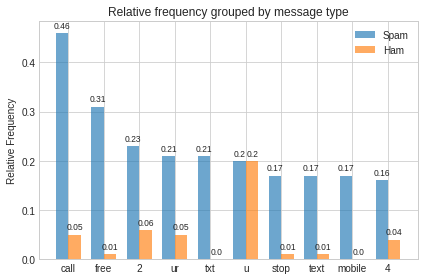

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

def plot_group_bar(target_words, aux_words, num_t, num_a):
  plt.style.use('seaborn-whitegrid')
  most_common = target_words.most_common(10)
  keys = [k for k, _ in most_common]
  
  target_values = [round(target_words[w]/num_t, 2) for w in keys]
  aux_values = [round(aux_words[w]/num_a, 2) for w in keys]
  x = np.arange(len(keys))
  width = 0.35
  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, target_values, width, label='Spam', alpha=0.65)
  rects2 = ax.bar(x + width/2, aux_values, width, label='Ham', alpha=0.65)
  ax.set_ylabel('Relative Frequency')
  ax.set_title('Relative frequency grouped by message type')
  ax.set_xticks(x)
  ax.set_xticklabels(keys)
  ax.legend()
  def autolabel(rects):
      for rect in rects:
          height = rect.get_height()
          ax.annotate('{}'.format(height),
                      xy=(rect.get_x() + rect.get_width() / 2, height),
                      xytext=(0, 3),
                      textcoords="offset points",
                      fontsize=8.5,
                      ha='center', va='bottom')
  autolabel(rects1)
  autolabel(rects2)
  fig.tight_layout()

plot_group_bar(train_spam_words, train_ham_words, num_spam, num_ham)


The model in question classifies each message by looking at the relative frequency with which words in the message appear in the spam training data versus in the ham training data. If the sum of relative frequencies are greater for spam words than ham words, then the message is classified as spam.

In [ ]:
def is_spam(message, spam_words, ham_words):
  spam_count = 0; ham_count = 0
  for word in message.split():
    if word in ham_words:
      ham_count += ham_words[word]
    if word in spam_words:
      spam_count += spam_words[word]
  return spam_count > ham_count

def norm(words, weight):
  return {w: words[w] * weight for w in words}

norm_s = norm(train_spam_words, 1/num_spam)
norm_h = norm(train_ham_words, 1/num_ham)
y_pred = [1 if is_spam(msg, norm_s, norm_h) else 0 for msg in x_test]

print('Accuracy: %.4f' % metrics.accuracy_score(y_test, y_pred))
print('Precision: %.4f' % metrics.precision_score(y_test, y_pred))
print('Recall: %.4f' % metrics.recall_score(y_test, y_pred))


Accuracy: 0.7423
Precision: 0.3533
Recall: 0.9898


From looking at the resulting scores we can deduce that the relative frequency classifier produces many *false positives* (with few *false negatives*). This shortfall can be alleviated by varying the relative weights of spam word and ham word frequencies. In fact, by doing this, we can visualise a well-known tradeoff between precision and recall. 

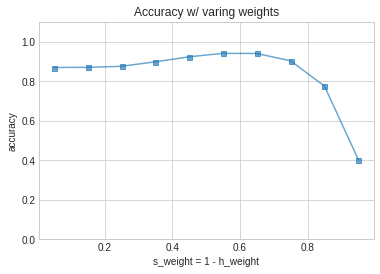

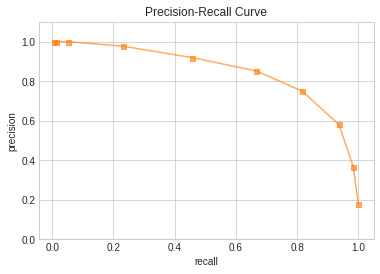

In [ ]:
def plot(xvalues, yvalues, title, labels, col):
  plt.style.use('seaborn-whitegrid')
  plt.title(title)
  plt.xlabel(labels[0])
  plt.ylabel(labels[1])
  plt.ylim(0, 1.1)
  plt.plot(xvalues, 
           yvalues, 
           marker='s',
           markersize=5,
           color=col,
           alpha=0.65)
  plt.show()

accuracy_scores = []
precision_scores = []
recall_scores = []
weights = np.arange(0.05, 1, 0.1).tolist()
for w in weights:
    norm_s = norm(train_spam_words, w)
    norm_h = norm(train_ham_words, 1 - w)
    y_pred = [1 if is_spam(msg, norm_s, norm_h) else 0 for msg in x_train]
    precision_scores.append(metrics.precision_score(y_train, y_pred))
    recall_scores.append(metrics.recall_score(y_train, y_pred))
    accuracy_scores.append(metrics.accuracy_score(y_train, y_pred))

plot(weights, 
     accuracy_scores, 
     title='Accuracy w/ varing weights', 
     labels=['s_weight = 1 - h_weight', 'accuracy'],
     col='tab:blue')

plot(recall_scores, 
     precision_scores, 
     title='Precision-Recall Curve', 
     labels=['recall', 'precision'],
     col='tab:orange')

The highest accuracy score on the training data is 0.9432 with corresponding precision and recall scores of 0.8656 and 0.6723 respectively. The weights that achieve these scores are 0.55 for spam frequencies and 0.45 for ham frequencies. When using these same weights for predictions on the test data we get considerably improved scores.

In [ ]:
norm_s = norm(train_spam_words, 0.55)
norm_h = norm(train_ham_words, 0.45)
y_pred = [1 if is_spam(msg, norm_s, norm_h) else 0 for msg in x_test]

print('Accuracy: %.4f' % metrics.accuracy_score(y_test, y_pred))
print('Precision: %.4f' % metrics.precision_score(y_test, y_pred))
print('Recall: %.4f' % metrics.recall_score(y_test, y_pred))

Accuracy: 0.9404
Precision: 0.8851
Recall: 0.6650


### Logistic Regression
One of two models discussed in lectures is that of logistic regression. We will look at an 'out-of-the-box' model provided by [scikit-learn](https://scikit-learn.org/) which applies regularisation by default. This model produces high precision scores which, as you can remember, is a characteristic we consider favourable. 

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression()
logistic_regression.fit(x_train_m, y_train)
y_pred = logistic_regression.predict(x_test_m)

print('Accuracy: %.4f' % metrics.accuracy_score(y_test, y_pred))
print('Precision: %.4f' % metrics.precision_score(y_test, y_pred))
print('Recall: %.4f' % metrics.recall_score(y_test, y_pred))

Accuracy: 0.9749
Precision: 0.9939
Recall: 0.8274


### Naive Bayes
The other model explored in lectures is the naive Bayes classifier. Here, we use a naive Bayes algorithm from scikit-learn implemented for multinomially distributed data. This algorithm is considered one of classic naive Bayes variants used for text classification (where the data is represented as word vector counts). This model achieves great scores all round.


In [ ]:
from sklearn.naive_bayes import MultinomialNB

np.random.seed(0)
multinomial_nb = MultinomialNB()
multinomial_nb.fit(x_train_m, y_train)
y_pred = multinomial_nb.predict(x_test_m)

print('Accuracy: %.4f' % metrics.accuracy_score(y_test, y_pred))
print('Precision: %.4f' % metrics.precision_score(y_test, y_pred))
print('Recall: %.4f' % metrics.recall_score(y_test, y_pred))

Accuracy: 0.9835
Precision: 0.9728
Recall: 0.9086


## Neural Network
We will now implement a simple feedforward neural network and see how it fairs against the previously explored methods.

### Initialisation
Before we can build our model, we need training, validation and test sets. The training set used in previous models is split to produce a new training set and a validation set. The test set is preserved for final model evaluation.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split

np.random.seed(0)
torch.manual_seed(0)

# x, y = data['processed_message'], data['target']
# x_train, x_test, y_train, y_test = train_test_split(x, y)
x_train_orig, y_train_orig = x_train.copy(), y_train.copy()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train)

train_spam = [m for m,t in zip(x_train, y_train) if t == 1]
train_ham = [m for m,t in zip(x_train, y_train) if t == 0]
train_spam_words = bag_of_words(train_spam)
train_ham_words = bag_of_words(train_ham)
train_words = train_spam_words + train_ham_words

### Architectures
The architecture of the model comprises an input layer, two hidden layers and an output layer. Each input to the neural network represents a message and is a vector whose size is the same as the vocabulary size of the training data. Each element in the vector contains the frequency with which a word in the message appears in the training data. The output layer produces the probability that a message is a spam message and the probability that it is a ham message.

In [ ]:
class Net(nn.Module):
  def __init__(self, num_labels, vocab_size, l1=100, l2=50):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(vocab_size, l1)
    self.fc2 = nn.Linear(l1, l2)
    self.fc3 = nn.Linear(l2, num_labels)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.softmax(self.fc3(x), dim=1)
    return x

num_labels = 2
vocab_size = len(train_words)
model = Net(num_labels, vocab_size)

###Train and predict
We now define the `train` and `predict` methods of our model. We explore two optimisation algorithms when training our model, namely SGD (stochastic gradient descent) and Adam's method. From a few simple test runs, we find that the Adam's method performs better than SGD. This is primarily because SGD is prone to overfitting and performs poorly on the validation set when trained for many epochs. Adam's method on the other hand doesn't see much degradation in performance when trained for many epochs. This is because PyTorch's implementation of Adam's method applies L2 regularization which helps prevent overfitting. To speed up training time we made use of Google Colab's GPU runtime environment and PyTorch's data parallelism constructs.

In [ ]:
def make_vector(message, words):
  vec = torch.zeros(len(words))
  for word in message:
    vec[words[word]] += 1
  return vec.view(1, -1)

def make_target(target):
  return torch.Tensor([[target, 1 - target]])

def train(model, x_train, y_train, x_val=None, y_val=None, epochs=10, lr=0.001):
  device = "cpu"
  if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:
      model = nn.DataParallel(model)
  model.to(device)

  loss_function = nn.BCELoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)
  # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

  running_losses, val_losses = [], []
  for epoch in range(epochs):
    running_loss = 0.0
    val_loss = 0.0
    for instance, target in zip(x_train, y_train):
      vec = make_vector(instance, train_words)
      target = make_target(target)
      vec, target = vec.to(device), target.to(device)
      model.zero_grad()
      y_pred = model(vec)
      loss = loss_function(y_pred, target)
      running_loss += loss.item()
      loss.backward()
      optimizer.step()
      
    # validation loss
    if x_val is not None:
      val_loss = 0
      for instance, target in zip(x_val, y_val):
        with torch.no_grad():
          vec = make_vector(instance, train_words)
          target = make_target(target)
          vec, target = vec.to(device), target.to(device)
          y_pred = model(vec)
          loss = loss_function(y_pred, target)
          val_loss += loss.item()
      
    running_losses.append(running_loss)
    val_losses.append(val_loss)

  running_losses = [l/len(x_train) for l in running_losses]
  if x_val is not None:
    val_losses = [l/len(x_val) for l in val_losses]
  return running_losses, val_losses


def predict(model, x, train_words):
  device = "cuda:0" if torch.cuda.is_available() else 'cpu'
  with torch.no_grad():
    y_pred = []
    for instance in x:
      vec = make_vector(instance, train_words).to(device)
      probs = model(vec)
      if probs[0][0] > probs[0][1]:
        y_pred.append(1)
      else:
        y_pred.append(0)
  return y_pred

### Hyperparameter tuning
For hyperparameter tuning, we opted for randomised search optimisation. The main reason for this approach is the computational time needed to train the neural network. By using randomised search, we can specify a computational budget in the form of `num_iter`, which allows the search time to be independent of the number of parameters and possible values. All explored parameter values and corresponding metric scores are saved to a `results.csv` file for further analysis. The randomised search optimisation is conducted over 50 search iterations and is evaluated using the validation set.



In [ ]:
param_dist = {
    'l1': stats.randint(2, 1500),
    'l2': stats.randint(2, 500),
    'lr': stats.loguniform(1e-5, 1e-2),
    'epochs': stats.randint(1, 30)
}

columns = list(param_dist.keys()) + ['precision', 'reccall', 'accuracy']
accuracy, precision, recall = [], [], []
num_iter = 0 # change to desired number of search iterations
for _ in range(num_iter):
  l1 = param_dist['l1'].rvs(1)[0]
  l2 = param_dist['l2'].rvs(1)[0]
  lr = param_dist['lr'].rvs(1)[0]
  epochs = param_dist['epochs'].rvs(1)[0]

  model = Net(num_labels, vocab_size, l1, l2)
  train(model, x_train, y_train, epochs=epochs, lr=lr)
  y_pred = predict(model, x_val, train_words)

  precision = metrics.precision_score(y_val, y_pred)
  recall = metrics.recall_score(y_val, y_pred)
  accuracy = metrics.accuracy_score(y_val, y_pred)

  r = pd.DataFrame([[l1, l2, lr, epochs, precision, recall, accuracy]], 
                   columns=columns)
  r.to_csv('results.csv', mode='a', header=False)

We use a correlation matrix to see the effect of different parameter values on model performance. We're interested in is the top right hand corner of the correlation matrix, where we can see the correlation coefficients between parameter values and resulting metric scores. We notice that smaller learning rates are generally preferred.


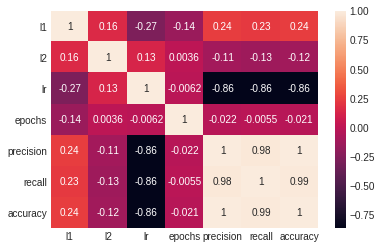

In [ ]:
import seaborn as sn

df_results = pd.read_csv('results.csv')
df_results = df_results.drop(columns=['Unnamed: 0'])

# needed due to random seed - better do to all search runs in a single execution
df_results = df_results.drop_duplicates()

corr_matrix = df_results.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

As we prefer higher precision scores over recall scores, we are going to isolate the top 10 runs with respect to precision. We notice that top scoring parameters comprise smaller hidden layer sizes, very small learning rates and many training epochs. Going forward we will choose the parameters of our best scoring run with respect to precision.

In [ ]:
df_results = df_results.sort_values(['precision'], ascending=False)
df_results.head(10)

,l1,l2,lr,epochs,precision,recall,accuracy
49,105,48,0.000025,14,0.982301,0.804348,0.972249
16,27,77,0.000040,13,0.982301,0.804348,0.972249
7,282,474,0.000295,27,0.974790,0.840580,0.976077
10,461,161,0.000016,27,0.974359,0.826087,0.974163
47,667,243,0.000016,23,0.974359,0.826087,0.974163
22,731,47,0.001623,7,0.973684,0.804348,0.971292
12,1044,484,0.000017,1,0.963964,0.775362,0.966507
14,333,465,0.000049,18,0.959677,0.862319,0.977033
45,841,181,0.000039,21,0.959016,0.847826,0.975120
4,1273,139,0.000960,14,0.957983,0.826087,0.972249


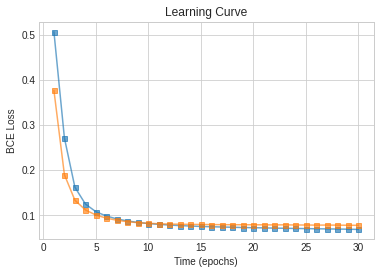

In [ ]:
def plot(df, title, labels):
  plt.style.use('seaborn-whitegrid')
  plt.title(title)
  plt.xlabel(labels[0])
  plt.ylabel(labels[1])
  xvalues = df['epochs']
  del df['epochs']
  for column in df.columns:
    yvalues = df[column]
    plt.plot(xvalues, 
            yvalues, 
            marker='s',
            markersize=5,
            alpha=0.65)
  plt.savefig('learning.png')
  plt.show()

l1, l2 = 100, 50
lr = 0.000025
epochs = 30
model = Net(num_labels, vocab_size, l1, l2)
losses, val_losses = train(model, x_train, 
                           y_train, x_val, y_val,
                           epochs=epochs, 
                           lr=lr)
df = pd.DataFrame()
df['epochs'] = [i+1 for i in range(epochs)]
df['running_losses'] = losses
df['val_losses'] = val_losses
plot(df, 'Learning Curve', ('Time (epochs)', 'BCE Loss'))

From the learning curves above we can deduce that the validation set doesn't benefit from epochs beyond 10. We will choose this as the number of epochs to train the model for final evaluation on our test set.

### Performance
To summarise, here are the parameters that produced the best results on our validation dataset. We will use these parameters to train the model on the original training set (which includes the validation set) and then evaluate the model on the test set.

In [ ]:
l1, l2 = 100, 50
lr = 0.000025
epochs = 25
val = (x_val, y_val)
model = Net(num_labels, vocab_size, l1, l2)
losses, val_losses = train(model, x_train_orig, y_train_orig,
                           epochs=epochs, 
                           lr=lr)

y_pred = predict(model, x_test, train_words)
print('Accuracy: %.4f' % metrics.accuracy_score(y_test, y_pred))
print('Precision: %.4f' % metrics.precision_score(y_test, y_pred))
print('Recall: %.4f' % metrics.recall_score(y_test, y_pred))

Accuracy: 0.9763
Precision: 0.9556
Recall: 0.8731
